# Análisis de Fase de Señales SPICE
Este notebook muestra cómo usar las funciones de `phase_analysis_utils.py` para cargar archivos SPICE y analizar diferencias de fase usando cruces al 50% (0.6 V).

In [81]:
from phase_analysis_utils import *

In [82]:
# Carga
time1, time2, time3, time4, vin1m, vin2m, vout1m, vout2m = load_spice_file("tb_QDLL_TOP_TT.txt")

# 1) Tiempo común (intersección)
time = common_time_vector(time1, time2, time3, time4, freq=200e6, n_per_period=500)

# 2) Remuestreo de cada señal a ese tiempo común
vin1  = resample_to_common_time(time, time1, vin1m)
vin2  = resample_to_common_time(time, time2, vin2m)
vout1 = resample_to_common_time(time, time3, vout1m)
vout2 = resample_to_common_time(time, time4, vout2m)


In [83]:
# Calcular diferencias de fase
results = analyze_signals(time, vin1, vin2, vout1, vout2)
for label, (phase, delay) in results.items():
    print(f"{label}: Fase = {phase:.2f}°, Retardo = {delay*1e9:.2f} ns")

phi_in: Fase = 72.00°, Retardo = 2.00 ns
phi_out: Fase = 288.97°, Retardo = -1.97 ns
phi_in_out: Fase = 258.82°, Retardo = 37.19 ns


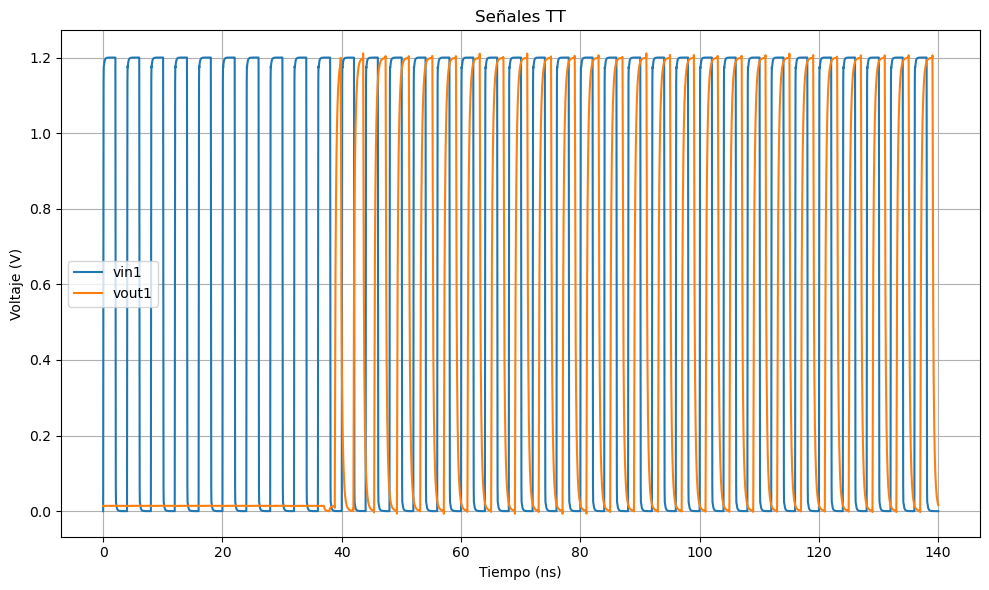

In [84]:
# Graficar las señales
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(time * 1e9, vin1, label='vin1')
#plt.plot(time * 1e9, vin2, label='vin2')
plt.plot(time * 1e9, vout1, label='vout1')
#plt.plot(time * 1e9, vout2, label='vout2')
plt.xlabel('Tiempo (ns)')
plt.ylabel('Voltaje (V)')
plt.title('Señales TT')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

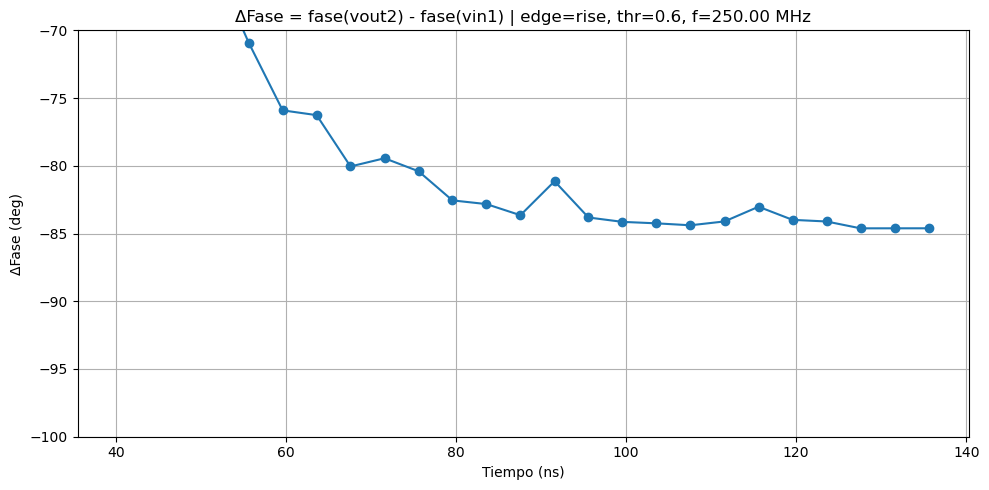

f = 249.99998112983724 MHz
Δphi = [ 40.47985094 -27.8434785  -54.56402017 -65.30383415 -70.93505239
 -75.90654519 -76.26086655 -80.04897232 -79.44283095 -80.40061869
 -82.55337034 -82.82656313 -83.64747878 -81.13902646 -83.81600914
 -84.13919061 -84.24804926 -84.39104302 -84.10744781 -83.02153191
 -83.98995222 -84.11045026 -84.61651137 -84.61477817 -84.61381814] deg
Δphi medio = -73.04246354309127 deg
último punto Δphi a t = 135.56397617823964 ns


In [85]:
#time1, time2, time3, time4, vin1, vin2, vout1, vout2 = load_spice_file("tb_QDLL_TOP_TT.txt")

res = phase_and_difference(
    vin1, time,
    vout2, time,
    threshold=0.6,
    freq=None,      # o poné 200e6 si querés fijo
    edge="rise",
    ref="out",      # clave: que el eje temporal siga a la salida
    plot=True
)

print("f =", res["freq"]/1e6, "MHz")
print("Δphi =", res["dphi"], "deg")
print("Δphi medio =", res["mean_dphi"], "deg")
print("último punto Δphi a t =", res["t_axis"][-1]*1e9, "ns")


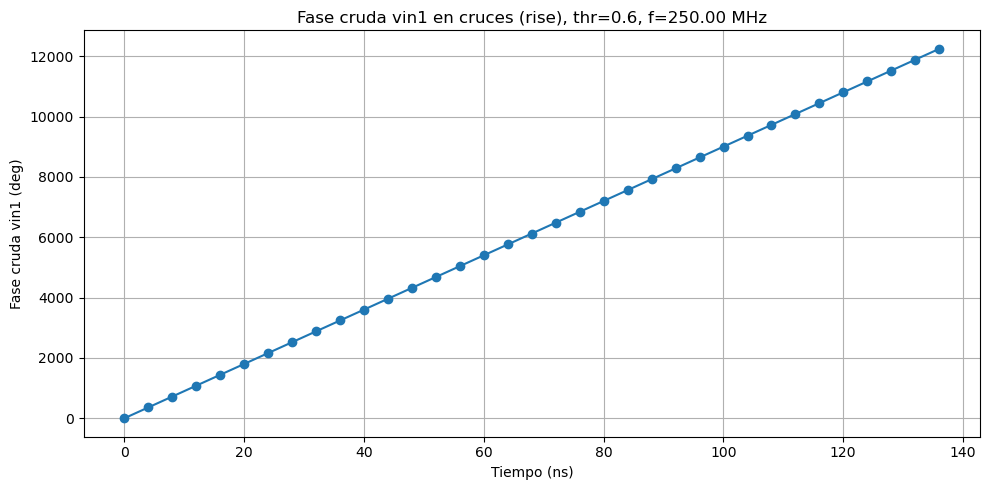

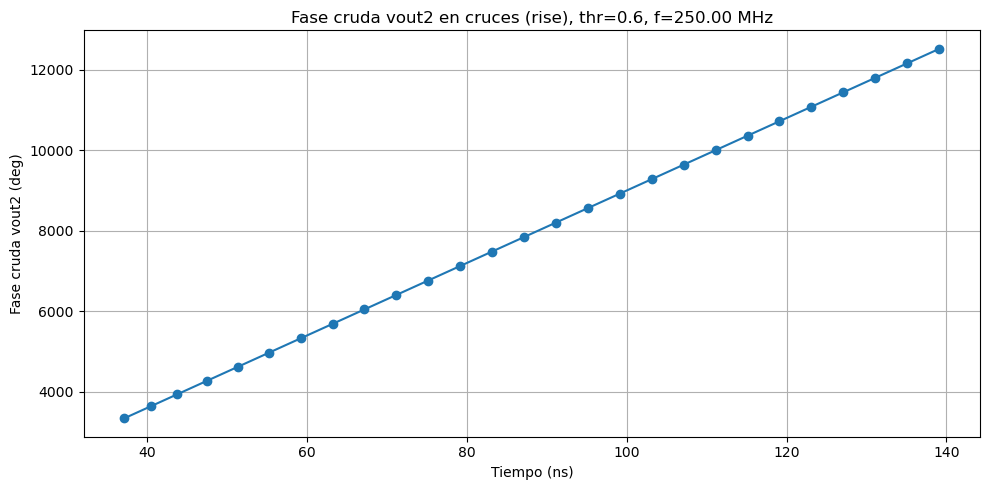

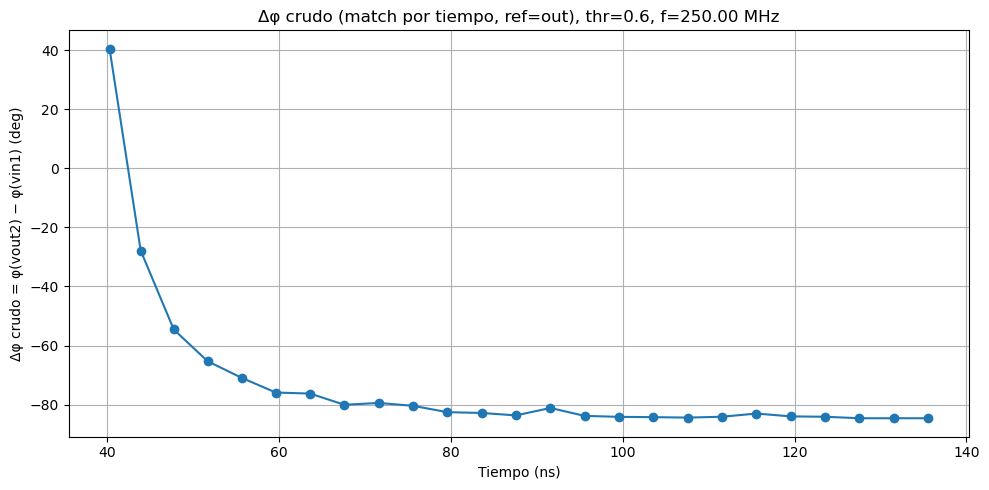

t1_fin [ns] = 140.0 | t2_fin [ns] = 140.0
N rises vin1 = 35 último [ns] = 136.03405298115825
N rises vout2= 27 último [ns] = 139.09390902266483
N pares Δφ  = 25 último t_axis [ns] = 135.56397617823964


In [86]:
(c_in, phi_in), (c_out, phi_out), (t_axis, dphi), f = plot_phi_crudo_y_delta(
    vin1, time,
    vout2, time,
    threshold=0.6,
    freq=None,      # o fijá 200e6 si querés
    edge="rise",
    ref="out"
)


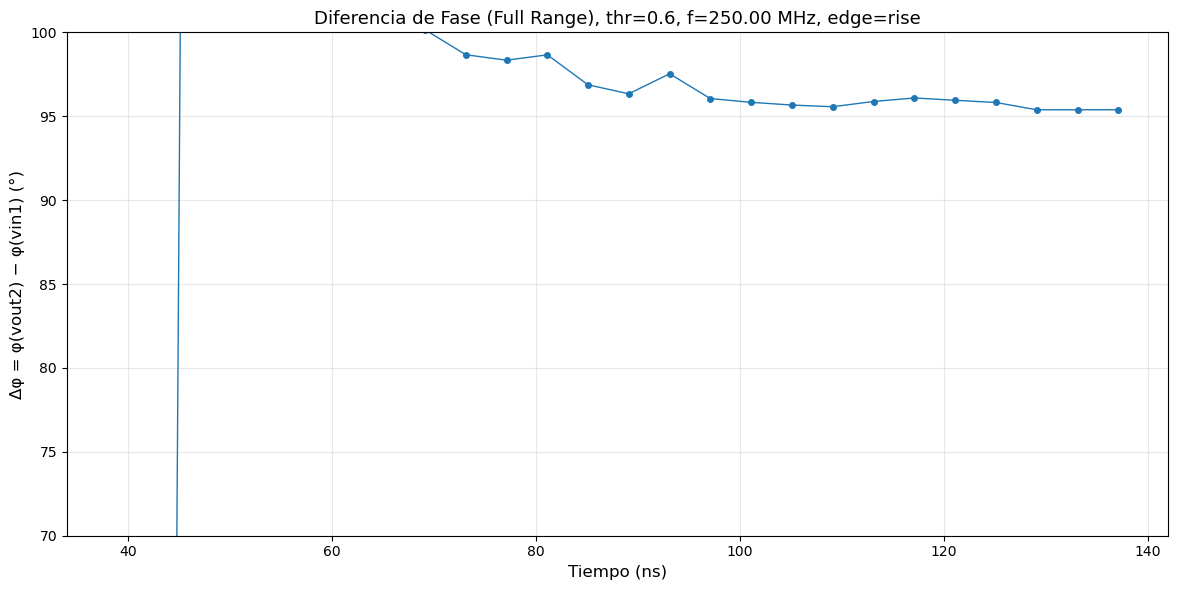


=== PHASE DIFFERENCE ANALYSIS ===
Simulation end time: 140.00 ns | 140.00 ns
Input crossings (vin1): 35, last at 136.03 ns
Output crossings (vout2): 26, last at 137.09 ns
Phase difference pairs: 26, last time: 137.09 ns
Frequency: 250.00 MHz
Mean phase difference: 82.32°
Std dev phase difference: 65.08°


In [87]:
# Plot full phase difference across entire simulation time
result_full = plot_phase_difference_full(
    vin1, time,
    vout1, time,
    threshold=0.6,
    freq=None,      # Auto-estimate from signal
    edge="rise"
)

### CORNERS

In [88]:
from phase_analysis_utils import *

# Cargar señales y tiempos para cada caso
t_ss, vin1_ss, _, vout1_ss, _ = load_spice_file("v1/tb_QDLL_TOP_SS.txt")
t_tt, vin1_tt, _, vout1_tt, _ = load_spice_file("v1/tb_QDLL_TOP_TT.txt")
t_ff, vin1_ff, _, vout1_ff, _ = load_spice_file("v1/tb_QDLL_TOP_FF.txt")

# Armar pares de señales (entrada-salida) y sus respectivos tiempos
signal_pairs = [(vin1_ss, vout1_ss), (vin1_tt, vout1_tt), (vin1_ff, vout1_ff)]
labels = ['SS', 'TT', 'FF']
time_arrays = [t_ss, t_tt, t_ff]

# Graficar diferencia de fase a lo largo del tiempo
compare_phase_vs_time_across_cases(signal_pairs, labels, time_arrays)



ValueError: too many values to unpack (expected 5)

In [ ]:
from phase_analysis_utils import *

# Calcular jitter
jitter_results = compare_jitter_across_cases(
    [vin1_ss, vin1_tt, vin1_ff],
    ['SS', 'TT', 'FF'],
    t_tt
)

for label, res in jitter_results.items():
    print(f"{label}: Jitter std = {res['jitter_std'] * 1e12:.2f} ps")


SS: Jitter std = 37.19 ps
TT: Jitter std = 0.02 ps
FF: Jitter std = 39.40 ps


In [ ]:
R = 2654*4
C = 2*600e-15
freq = 1/(2*np.pi*R*C)
print("freq: ", freq/(1e6), " MHz")

freq:  12.493323214322354  MHz
